In [1]:
import os
import time
import json
import numpy as np
import torch
import joblib
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from data.trajectory_loader import load_dataset
from models.modified_attention_bi_gru_predictor import TrajPredictor
from utils.logger import get_logger
from utils.model_evaluator import evaluate_metrics_multi_agent as evaluate
from utils.plot_generator import plot_trajectories
from utils.scaler import scale_per_agent

In [2]:
# pylint: disable=all
# Data settings and parameters
DATA_TYPE = "zurich"  # Options: "zurich", "quadcopter", "mixed"
AGENTS = 3  # Number of agents or drones
LOOK_BACK = 50  # Number of past time steps to use as input
FORWARD_LEN = 5  # Number of future time steps to predict
FEATURES_PER_AGENT = 3  # x, y, z

# Training parameters
BATCH_SIZE = 32
EPOCHS = 500
LEARNING_RATE = 1e-3

# Plotting parameters
NUM_PLOTS = 7  # number of plots to generate

In [3]:
# Setup logger and experiment folder
logger, exp_dir = get_logger()
os.makedirs(exp_dir, exist_ok=True)

logger.info("Experiment started")
logger.info("Experiment folder: %s", exp_dir)
logger.info("Dataset used: %s", DATA_TYPE)
logger.info("Number of drones: %d", AGENTS)

2025-09-25 18:14:44,541 - INFO - Experiment started
2025-09-25 18:14:44,542 - INFO - Experiment folder: experiments/20250925_181444
2025-09-25 18:14:44,542 - INFO - Dataset used: zurich
2025-09-25 18:14:44,543 - INFO - Number of drones: 3


In [4]:
# Load DataFrame
df = load_dataset(
    DATA_TYPE,
    min_rows=800,
    num_flights=AGENTS,
)

# Prepare sequences
# Track trajectory indices to be used in plotting later
X, y, trajectory_ids = [], [], []

for traj_idx in df["trajectory_index"].unique():
    traj_df = df[df["trajectory_index"] == traj_idx].reset_index(drop=True)

    # Drop trajectory_index for features
    traj_data = traj_df.drop(columns=["trajectory_index"]).values.astype(np.float32)
    n_rows = traj_data.shape[0]

    seq_count = n_rows - LOOK_BACK - FORWARD_LEN + 1
    for i in range(seq_count):
        seq_X = traj_data[i : i + LOOK_BACK]  # shape (LOOK_BACK, features)
        seq_y = traj_data[i + LOOK_BACK + FORWARD_LEN - 1]  # shape (features,)

        X.append(seq_X)
        y.append(seq_y)
        trajectory_ids.append(traj_idx)


In [5]:
# Convert to NumPy arrays
X = np.array(X, dtype=np.float32)  # (num_sequences, LOOK_BACK, features)
y = np.array(y, dtype=np.float32)  # (num_sequences, features)
trajectory_ids = np.array(trajectory_ids)

# Split train/test
X_train, X_test, y_train, y_test, traj_train, traj_test = train_test_split(
    X, y, trajectory_ids, test_size=0.2, shuffle=False
)

# Get feature dimension dynamically
num_features_X = X_train.shape[-1]

# Scale data to [0, 1]
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Fit scalers on training data only
X_train_scaled = scale_per_agent(X_train, scaler_X, FEATURES_PER_AGENT, fit=True)
X_test_scaled = scale_per_agent(X_test, scaler_X, FEATURES_PER_AGENT, fit=False)

# y is already 2D
y_train_scaled = scale_per_agent(y_train, scaler_y, FEATURES_PER_AGENT, fit=True)
y_test_scaled = scale_per_agent(y_test, scaler_y, FEATURES_PER_AGENT, fit=False)

# Save scalers
joblib.dump(scaler_X, os.path.join(exp_dir, "scaler_X.pkl"))
joblib.dump(scaler_y, os.path.join(exp_dir, "scaler_y.pkl"))

# Convert to tensors
X_train_tensor = torch.tensor(
    X_train_scaled, dtype=torch.float32
)  # (num_sequences, LOOK_BACK, features)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

# Create DataLoaders
train_loader = DataLoader(
    TensorDataset(X_train_tensor, y_train_tensor), batch_size=BATCH_SIZE, shuffle=True
)
test_loader = DataLoader(
    TensorDataset(X_test_tensor, y_test_tensor), batch_size=BATCH_SIZE, shuffle=False
)

In [6]:
# Log dataset sizes
total_sequences = X_train_tensor.shape[0] + X_test_tensor.shape[0]
logger.info("Total sequences: %d", total_sequences)
logger.info("Train sequences: %s", X_train_tensor.shape)
logger.info("Test sequences: %s", X_test_tensor.shape)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info("Using device: %s", device)

2025-09-25 18:14:44,935 - INFO - Total sequences: 23126
2025-09-25 18:14:44,937 - INFO - Train sequences: torch.Size([18500, 50, 9])
2025-09-25 18:14:44,937 - INFO - Test sequences: torch.Size([4626, 50, 9])
2025-09-25 18:14:44,938 - INFO - Using device: cpu


In [7]:
# Model, criterion, optimizer
model_params = {
    "enc_hidden_size": 64,
    "dec_hidden_size": 64,
    "num_layers": 1,
}
model = TrajPredictor(**model_params).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Log model info
logger.info("Model module: %s", model.__class__.__module__)
logger.info("Model architecture:\n%s", model)

2025-09-25 18:14:45,911 - INFO - Model module: models.modified_attention_bi_gru_predictor
2025-09-25 18:14:45,912 - INFO - Model architecture:
TrajPredictor(
  (encoder): GRU(3, 64, batch_first=True, bidirectional=True)
  (attention): Attention(
    (attn): Linear(in_features=192, out_features=64, bias=True)
    (v): Linear(in_features=64, out_features=1, bias=False)
  )
  (enc_to_dec): Linear(in_features=128, out_features=64, bias=True)
  (decoder): GRU(131, 64, batch_first=True)
  (fc_out): Linear(in_features=64, out_features=3, bias=True)
)


In [8]:
# Log training time
training_start = time.time()

# Early stopping parameters
patience = 15
best_loss = float("inf")
epochs_no_improve = 0
early_stop = False

# Training Loop
model.train()
try:
    for epoch in range(EPOCHS):
        total_loss = 0.0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            optimizer.zero_grad()
            pred = model(batch_x)
            loss = criterion(pred, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        logger.info("Epoch %d/%d - Train Loss: %.7f", epoch + 1, EPOCHS, avg_loss)

        # Early stopping
        if avg_loss < best_loss:
            best_loss = avg_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), os.path.join(exp_dir, "best_model.pt"))
        else:
            epochs_no_improve += 1

        # If no improvement for 'patience' epochs, stop training
        if epochs_no_improve >= patience:
            logger.info("Early stopping triggered after %d epochs", epoch + 1)
            early_stop = True
            break

except KeyboardInterrupt:
    logger.warning("Training interrupted by user! Running evaluation...")

# Save last-epoch model
finally:
    torch.save(model.state_dict(), os.path.join(exp_dir, "last_model.pt"))

# If training completed without early stopping
if not early_stop:
    logger.info("Training finished without early stopping.")

# Log total training time
training_end_time = time.time()
elapsed_time = training_end_time - training_start
logger.info("Total training time: %.2f seconds", elapsed_time)

2025-09-25 18:15:17,758 - INFO - Epoch 1/500 - Train Loss: 0.0033668
2025-09-25 18:15:47,896 - INFO - Epoch 2/500 - Train Loss: 0.0000390
2025-09-25 18:16:17,933 - INFO - Epoch 3/500 - Train Loss: 0.0000215
2025-09-25 18:16:48,209 - INFO - Epoch 4/500 - Train Loss: 0.0000207
2025-09-25 18:17:18,274 - INFO - Epoch 5/500 - Train Loss: 0.0000223
2025-09-25 18:17:48,649 - INFO - Epoch 6/500 - Train Loss: 0.0000219
2025-09-25 18:17:59,405 - WARNING - Training interrupted by user! Running evaluation...
2025-09-25 18:17:59,407 - INFO - Training finished without early stopping.
2025-09-25 18:17:59,407 - INFO - Total training time: 193.49 seconds


In [9]:
# Evaluation parameters
all_preds, all_trues = [], []
inference_times = []
test_loss = 0.0
total_sequences = 0

model.eval()
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        total_sequences += batch_x.size(0)

        start_time = time.time()
        outputs = model(batch_x)
        end_time = time.time()

        # Record inference time per batch
        inference_times.append(end_time - start_time)

        # Compute test loss
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()

        # Store predictions and true values
        all_preds.append(outputs.cpu())
        all_trues.append(batch_y.cpu())

# Compute average test loss
avg_test_loss = test_loss / len(test_loader)

# Compute total inference time, average inference time per batch and per sequence
total_inf_time = sum(inference_times)
avg_inf_time_per_seq = total_inf_time / total_sequences
avg_inf_time_per_batch = total_inf_time / len(test_loader)

# Log final test metrics
logger.info("Test Loss (scaled): %.7f", avg_test_loss)
logger.info("Average inference time per sequence: %.6f seconds", avg_inf_time_per_seq)
logger.info("Average inference time per batch: %.6f seconds", avg_inf_time_per_batch)

2025-09-25 18:18:03,671 - INFO - Test Loss (scaled): 0.0000307
2025-09-25 18:18:03,672 - INFO - Average inference time per sequence: 0.000538 seconds
2025-09-25 18:18:03,672 - INFO - Average inference time per batch: 0.017150 seconds


In [10]:
# Concatenate all batches
y_pred = torch.cat(all_preds, dim=0)
y_true = torch.cat(all_trues, dim=0)

# Compute evaluation metrics (inverse scaling applied)
mse, rmse, mae, ede, axis_mse, axis_rmse, axis_mae = evaluate(
    y_true, y_pred, scaler_y, num_agents=AGENTS
)

mse_x, mse_y, mse_z = axis_mse
rmse_x, rmse_y, rmse_z = axis_rmse
mae_x, mae_y, mae_z = axis_mae

# Log metrics per axis and overall
logger.info(
    "Test Mean Squared Error (MSE) per axis (averaged over %d agents): x=%.6f, y=%.6f, z=%.6f meters^2",
    AGENTS,
    mse_x,
    mse_y,
    mse_z,
)
logger.info("Test Mean Squared Error (MSE) overall: %.6f meters^2", mse)

logger.info(
    "Test Root Mean Squared Error (RMSE) per axis (averaged over %d agents): x=%.6f, y=%.6f, z=%.6f meters",
    AGENTS,
    rmse_x,
    rmse_y,
    rmse_z,
)
logger.info("Test Root Mean Squared Error (RMSE) overall: %.6f meters", rmse)

logger.info(
    "Test Mean Absolute Error (MAE) per axis (averaged over %d agents): x=%.6f, y=%.6f, z=%.6f meters",
    AGENTS,
    mae_x,
    mae_y,
    mae_z,
)
logger.info("Test Mean Absolute Error (MAE) overall: %.6f meters", mae)

logger.info(
    "Test Euclidean Distance Error (EDE) (averaged over all agents): %.6f meters", ede
)

2025-09-25 18:18:05,126 - INFO - Test Mean Squared Error (MSE) per axis (averaged over 3 agents): x=0.919336, y=2.516674, z=0.352568 meters^2
2025-09-25 18:18:05,127 - INFO - Test Mean Squared Error (MSE) overall: 1.262861 meters^2
2025-09-25 18:18:05,128 - INFO - Test Root Mean Squared Error (RMSE) per axis (averaged over 3 agents): x=0.958820, y=1.586403, z=0.593775 meters
2025-09-25 18:18:05,129 - INFO - Test Root Mean Squared Error (RMSE) overall: 1.123771 meters
2025-09-25 18:18:05,129 - INFO - Test Mean Absolute Error (MAE) per axis (averaged over 3 agents): x=0.768286, y=1.354246, z=0.455391 meters
2025-09-25 18:18:05,130 - INFO - Test Mean Absolute Error (MAE) overall: 0.859305 meters
2025-09-25 18:18:05,131 - INFO - Test Euclidean Distance Error (EDE) (averaged over all agents): 1.779479 meters


In [11]:
# Save config / hyperparameters
config = {
    "device": str(device),
    "model_module": model.__class__.__module__,
    "model_class": model.__class__.__name__,
    "model_params": model_params,
    "DATA_TYPE": DATA_TYPE,
    "AGENTS": AGENTS,
    "LOOK_BACK": LOOK_BACK,
    "FORWARD_LEN": FORWARD_LEN,
    "EPOCHS": EPOCHS,
    "BATCH_SIZE": BATCH_SIZE,
    "LEARNING_RATE": LEARNING_RATE,
}

config_path = os.path.join(exp_dir, "config.json")
with open(config_path, "w", encoding="utf-8") as f:
    json.dump(config, f, indent=4)

logger.info("Config saved to %s", config_path)

2025-09-25 18:18:09,843 - INFO - Config saved to experiments/20250925_181444/config.json


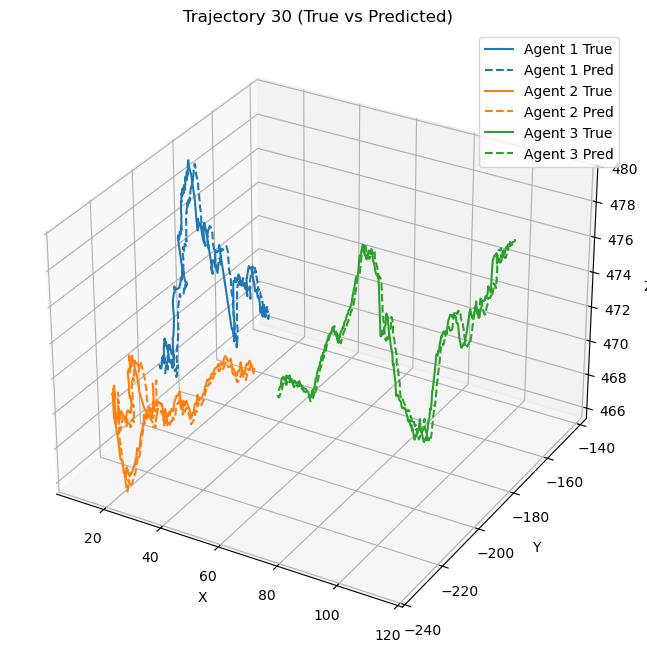

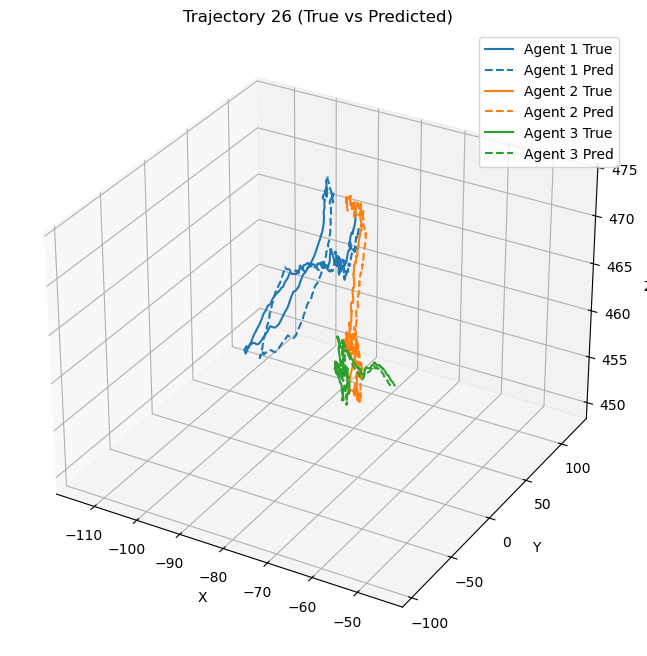

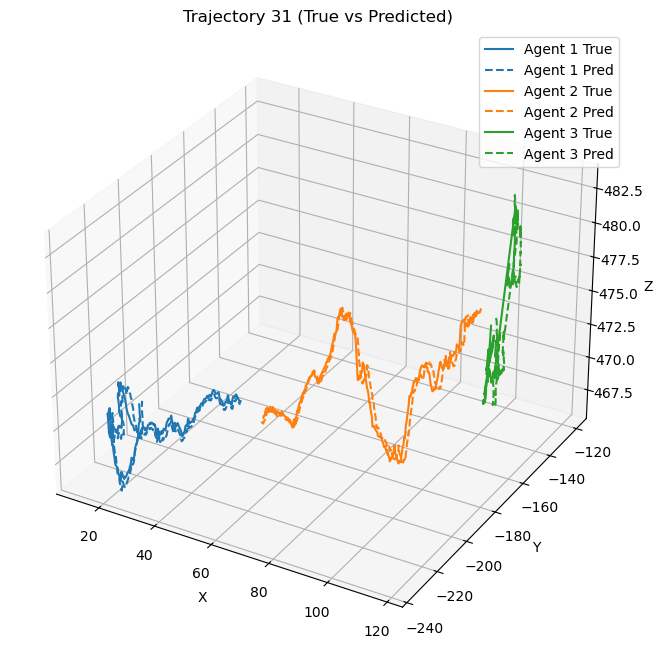

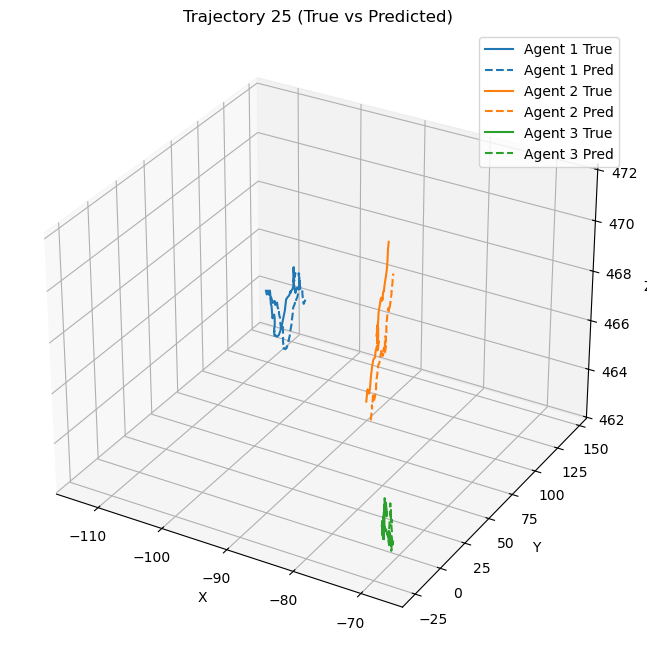

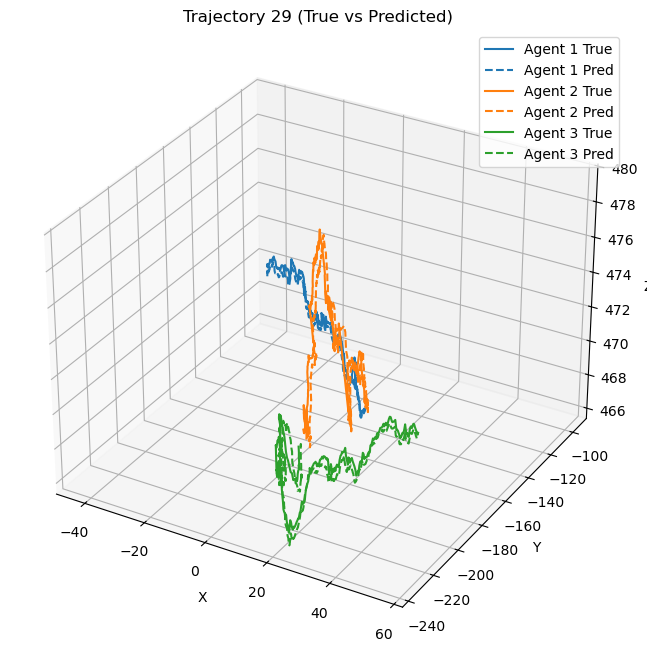

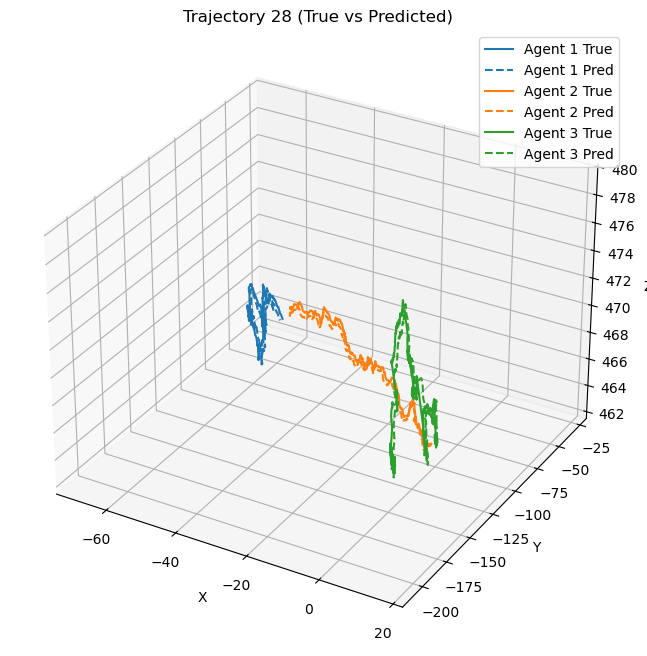

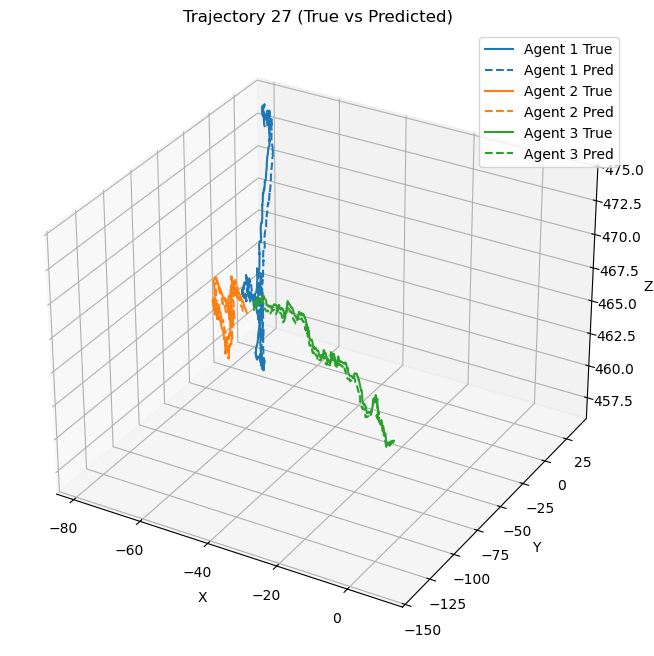

In [12]:
# Group results back by trajectory_index
traj_test = traj_test[: len(y_true)]  # align just in case
unique_trajs = np.unique(traj_test)

# Randomly select trajectories to plot
plot_trajs = np.random.choice(
    unique_trajs, size=min(NUM_PLOTS, len(unique_trajs)), replace=False
).tolist()

# Plot trajectories using the helper function
plot_trajectories(
    y_true=y_true.numpy(),
    y_pred=y_pred.numpy(),
    traj_ids=traj_test,
    plot_trajs=plot_trajs,
    scaler=scaler_y,
    agents=AGENTS,
    save_dir=exp_dir,
)